# Learn Lorenz Attractor Dynamics
This notebook presents a simple architecture to learn the dynamics of the [Lorenz Attractor](https://en.wikipedia.org/wiki/Lorenz_system).

In [1]:
import torch
import pytorch_lightning as pl
import torchmetrics
import numpy as np
import scipy
from scipy.integrate import odeint

from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

import pandas as pd
import plotnine as p9

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

## Data Generation
We generate trajectories of the Lorenz attractor defined by
$$\begin{align}
{\frac {\mathrm {d} x}{\mathrm {d} t}}&=\sigma (y-x)\\
{\frac {\mathrm {d} y}{\mathrm {d} t}}&=x(\rho -z)-y\\
{\frac {\mathrm {d} z}{\mathrm {d} t}}&=xy-\beta z
\end{align}$$

- Train set has 100 trajectories of 20 seconds;
- Validation set has 10 trajectories;
- Test set has 5 trajectories.

In [2]:
dt = 0.01
T = 20
t = np.arange(0, T+dt, dt)
beta = 8/3
sigma = 10
rho = 28

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

def generate_data(dt, t, beta, sigma, rho, x_0):
    x_t = np.asarray([odeint(lorenz_deriv, x0_j, t) for x0_j in x_0])
    return x_t

### Train Set

In [3]:
n_trajectories = 100
np.random.seed(123)
r = 30
x0 = - r // 2 + r * np.random.random((n_trajectories, 3))
x_t_train = generate_data(dt, t, beta, sigma, rho, x0)

In [4]:
input_train = x_t_train[:, :-1, :].reshape(-1, 3)
output_train = x_t_train[:, 1:, :].reshape(-1, 3)

(100, 2002, 3)


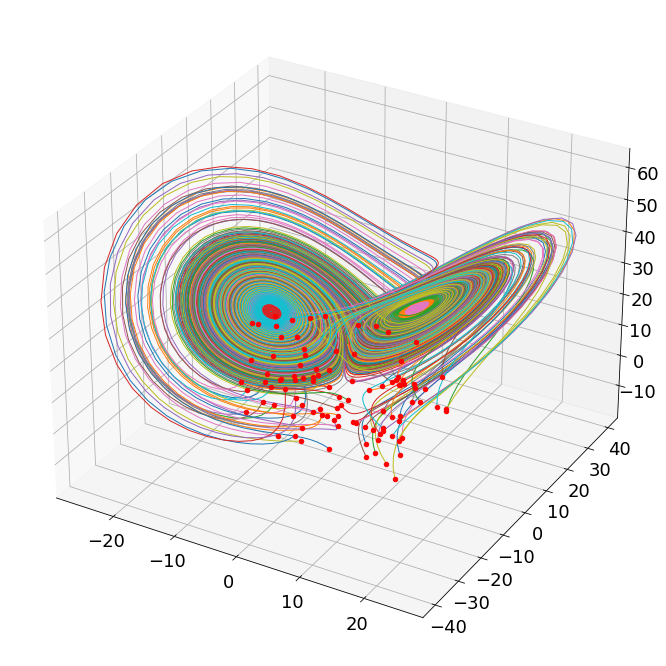

In [5]:
print(x_t_train.shape)
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
for j in range(x_t_train.shape[0]):
    x, y, z = x_t_train[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x[0],y[0],z[0],color='r')
plt.savefig("training_set.png")
plt.show()

### Validation Set

In [6]:
n_trajectories = 10
np.random.seed(123)
x0 = -15 + 30 * np.random.random((n_trajectories, 3))
x_t_val = generate_data(dt, t, beta, sigma, rho, x0)

(10, 2002, 3)


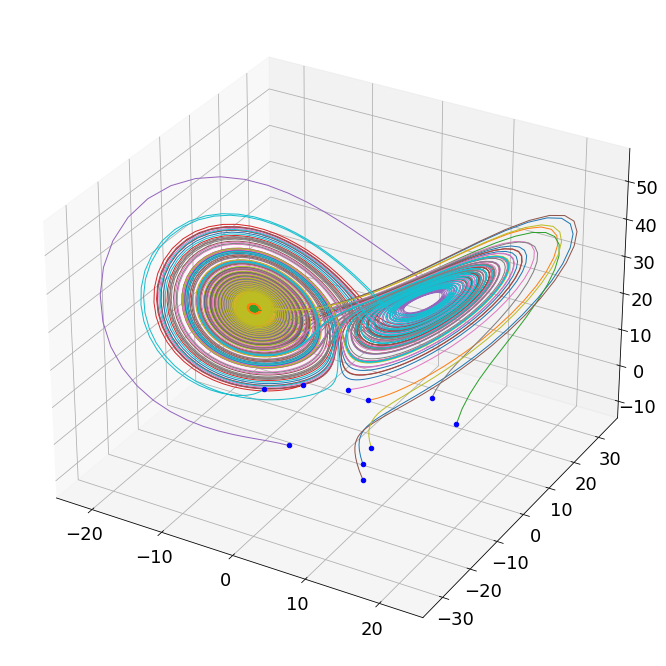

In [7]:
print(x_t_val.shape)
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
for j in range(x_t_val.shape[0]):
    x, y, z = x_t_val[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x[0],y[0],z[0],color='b')
plt.show()

In [8]:
input_val = x_t_val[:, :-1, :].reshape(-1, 3)
output_val = x_t_val[:, 1:, :].reshape(-1, 3)

### Test Set

In [9]:
n_trajectories = 5
np.random.seed(123)
x0 = -15 + 30 * np.random.random((n_trajectories, 3))
x_t_test = generate_data(dt, t, beta, sigma, rho, x0)

(5, 2002, 3)


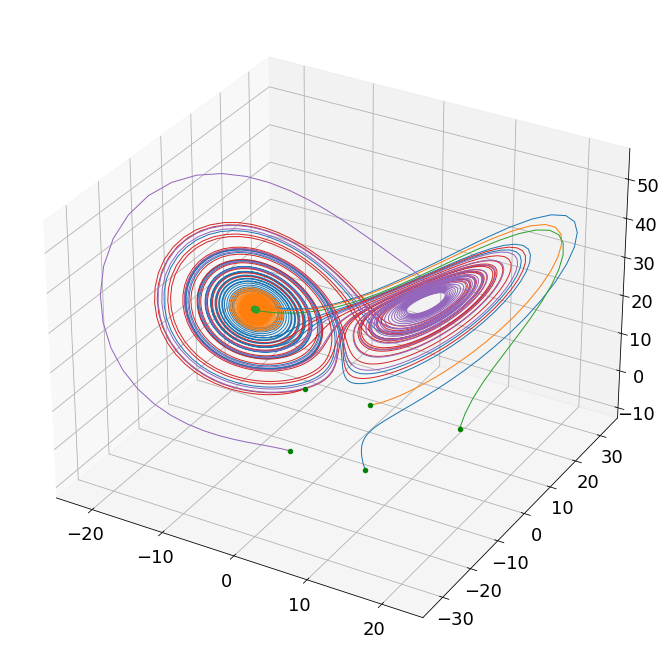

In [10]:
print(x_t_test.shape)
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
for j in range(x_t_test.shape[0]):
    x, y, z = x_t_test[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x[0],y[0],z[0],color='g')
plt.show()

In [11]:
input_test = x_t_test[:, :-1, :].reshape(-1, 3)
output_test = x_t_test[:, 1:, :].reshape(-1, 3)

In [12]:
class Model(pl.LightningModule):
    
    def __init__(self, n_features=16):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(3, n_features),
            torch.nn.SiLU(),
            torch.nn.Linear(n_features, n_features),
            torch.nn.SiLU(),
            torch.nn.Linear(n_features, 3)
        )
        self.criterion = torchmetrics.MeanSquaredError()
    
    def forward(self, x):
        return self.network(x)
    
    def step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1E-3, weight_decay=1E-4)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.995),
            'name': 'lr'
        }
        return [optimizer], [lr_scheduler]

In [13]:
device = torch.device("cuda")

## Learning the Derivative
We want to learn $\frac{x_{t+1} - x_t}{\Delta t}$ given $x_t$.

In [14]:
input_train = x_t_train[:, :-1, :].reshape(-1, 3)
x_mu, x_std = np.mean(input_train, axis=0), np.std(input_train, axis=0)
input_train = (input_train - x_mu) / x_std
output_train = (x_t_train[:, 1:, :].reshape(-1, 3) - x_t_train[:, :-1, :].reshape(-1, 3)) / dt
v_mu, v_std = np.mean(output_train, axis=0), np.std(output_train, axis=0)
output_train = (output_train - v_mu) / v_std

In [15]:
input_val = x_t_val[:, :-1, :].reshape(-1, 3)
input_val = (input_val - x_mu) / x_std
output_val = (x_t_val[:, 1:, :].reshape(-1, 3) - x_t_val[:, :-1, :].reshape(-1, 3)) / dt
output_val = (output_val - v_mu) / v_std

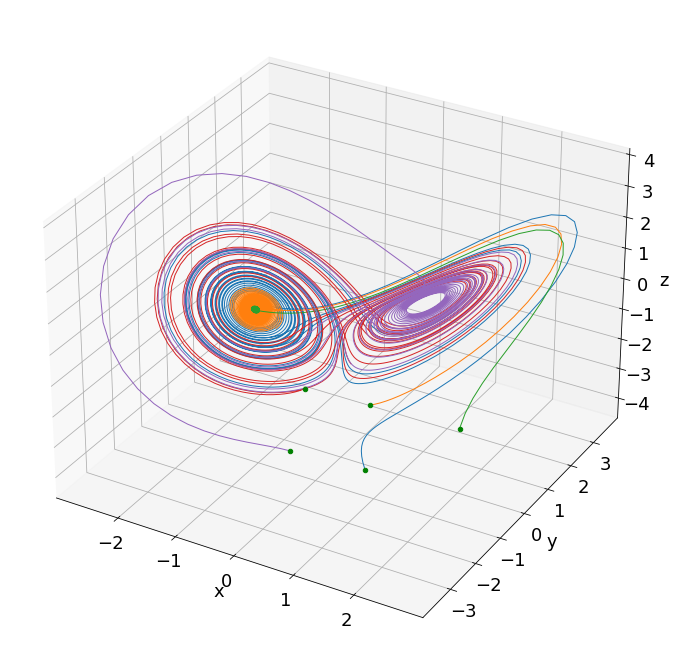

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(x_t_test.shape[0]):
    x, y, z = input_val.reshape(-1, t.size - 1, 3)[j, :].T
    #xd, yd, zd = x_pred[j, :10, :].T
    ax.plot(x, y, z, linewidth=1)
    #ax.plot(xd, yd, zd, '--', lw=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x[0], y[0], z[0], color='g')
             
# ax.view_init()
plt.show()

In [17]:
print(f"Reconstruction error {np.mean(((x_t_val[:, 1:, :] - x_t_val[:, :-1, :]).reshape(-1, 3) / dt - (output_val * v_std + v_mu)) ** 2):1.2e}")

Reconstruction error 4.93e-30


In [ ]:
model = Model(512)
logger = pl.loggers.CSVLogger("logs", name="Lorenz")
checkpoint_callback = pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_loss")
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')
train_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(input_train).float(), torch.from_numpy(output_train).float()), batch_size=64)
val_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(input_val).float(), torch.from_numpy(output_val).float()), batch_size=64)
trainer = pl.Trainer(accelerator="gpu", gpus=1, max_epochs=100, logger=logger, callbacks=[checkpoint_callback, lr_monitor])
trainer.fit(model, train_dataloader, val_dataloader)

Plot the training losses.

In [21]:
version = 0

In [22]:
log_file = f"logs/Lorenz/version_{version}/metrics.csv"
train_log = pd.read_csv(log_file)

In [23]:
train_df = train_log.loc[~train_log["train_loss_epoch"].isna(), ["epoch", "train_loss_epoch"]].reset_index(drop=True).copy()
train_df.rename(columns={"train_loss_epoch": "loss"}, inplace=True)
train_df["set"] = "train"
val_df = train_log.loc[~train_log["val_loss"].isna(), ["epoch", "val_loss"]].reset_index(drop=True).copy()
val_df.rename(columns={"val_loss": "loss"}, inplace=True)
val_df["set"] = "val"
loss_df = pd.concat([train_df, val_df])

/home/lucas/.local/lib/python3.8/site-packages/plotnine/ggplot.py:757: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/lucas/.local/lib/python3.8/site-packages/plotnine/ggplot.py:760: PlotnineWarning: Filename: train_version_0.png


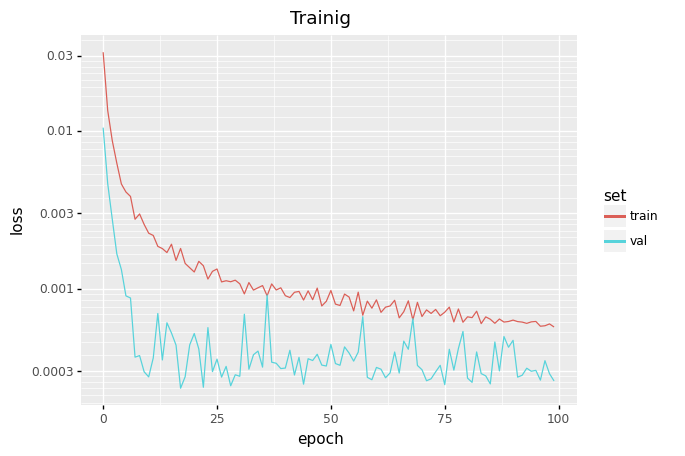

<ggplot: (8730714972441)>

In [24]:
p = p9.ggplot(loss_df, p9.aes(x='epoch', y='loss', color='set'))
p += p9.geom_line()
p += p9.scale_y_log10()
p += p9.labs(title="Trainig") 
p.save(f"train_version_{version}.png")
p

In [25]:
model = Model.load_from_checkpoint("logs/Lorenz/version_0/checkpoints/epoch=17-step=56286.ckpt", n_features=512)
model.eval()

Model(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SiLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (criterion): MeanSquaredError()
)

In [26]:
@torch.no_grad()
def rollout_data(model, x0, t):
    x_rollout = []
    x_rollout.append(x0)

    def foo(x, *args):
        x_input = (torch.from_numpy(x) - x_mu) / x_std
        x_input = x_input.float().to(model.device)
        dx_pred = model(x_input).cpu().numpy() * v_std + v_mu
        return x + dx_pred * dt
    
    x_prev = x0.copy()
    for _ in t[1:]:
        x_t = foo(x_prev)
        x_rollout.append(x_t)
        x_prev = x_t
    return np.asarray(x_rollout)

In [27]:
x_0_test = x_t_test[:, 0, :]

In [28]:
x_pred = rollout_data(model, x_0_test, t)
x_pred = np.moveaxis(x_pred, 0, 1)

Plot the predicted dynamics against the target one.

(5, 2002, 3)
(5, 2002, 3)


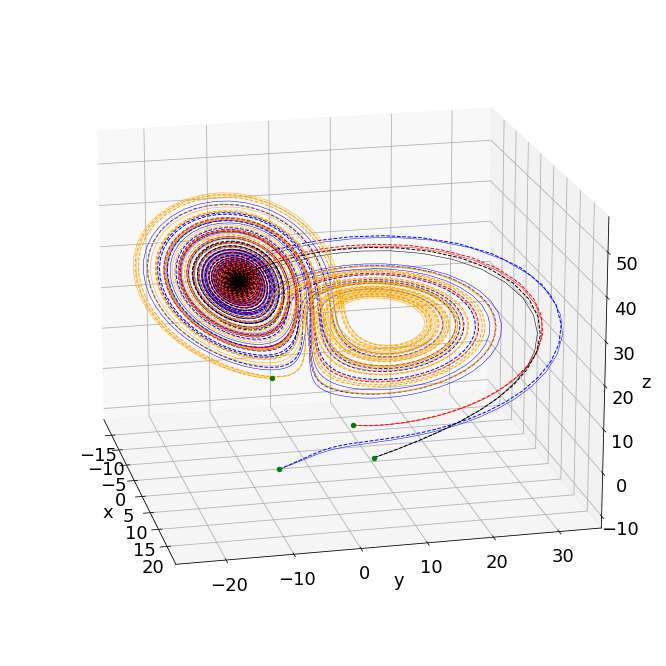

In [32]:
print(x_t_test.shape)
print(x_pred.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j, color in zip(range(x_t_test.shape[0]), ["blue", "red", "black", "orange"]):
    x, y, z = x_t_test[j, :, :].T
    xd, yd, zd = x_pred[j, :, :].T
    ax.plot(x, y, z, lw=.5, c=color)
    ax.plot(xd, yd, zd, '--', lw=1, c=color)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x[0], y[0], z[0], color='g')
             
ax.view_init(18, -13)
plt.savefig("dynamics_training_set_test_result_trajetories.png")
plt.show()

(5, 2002, 3)
(5, 2002, 3)


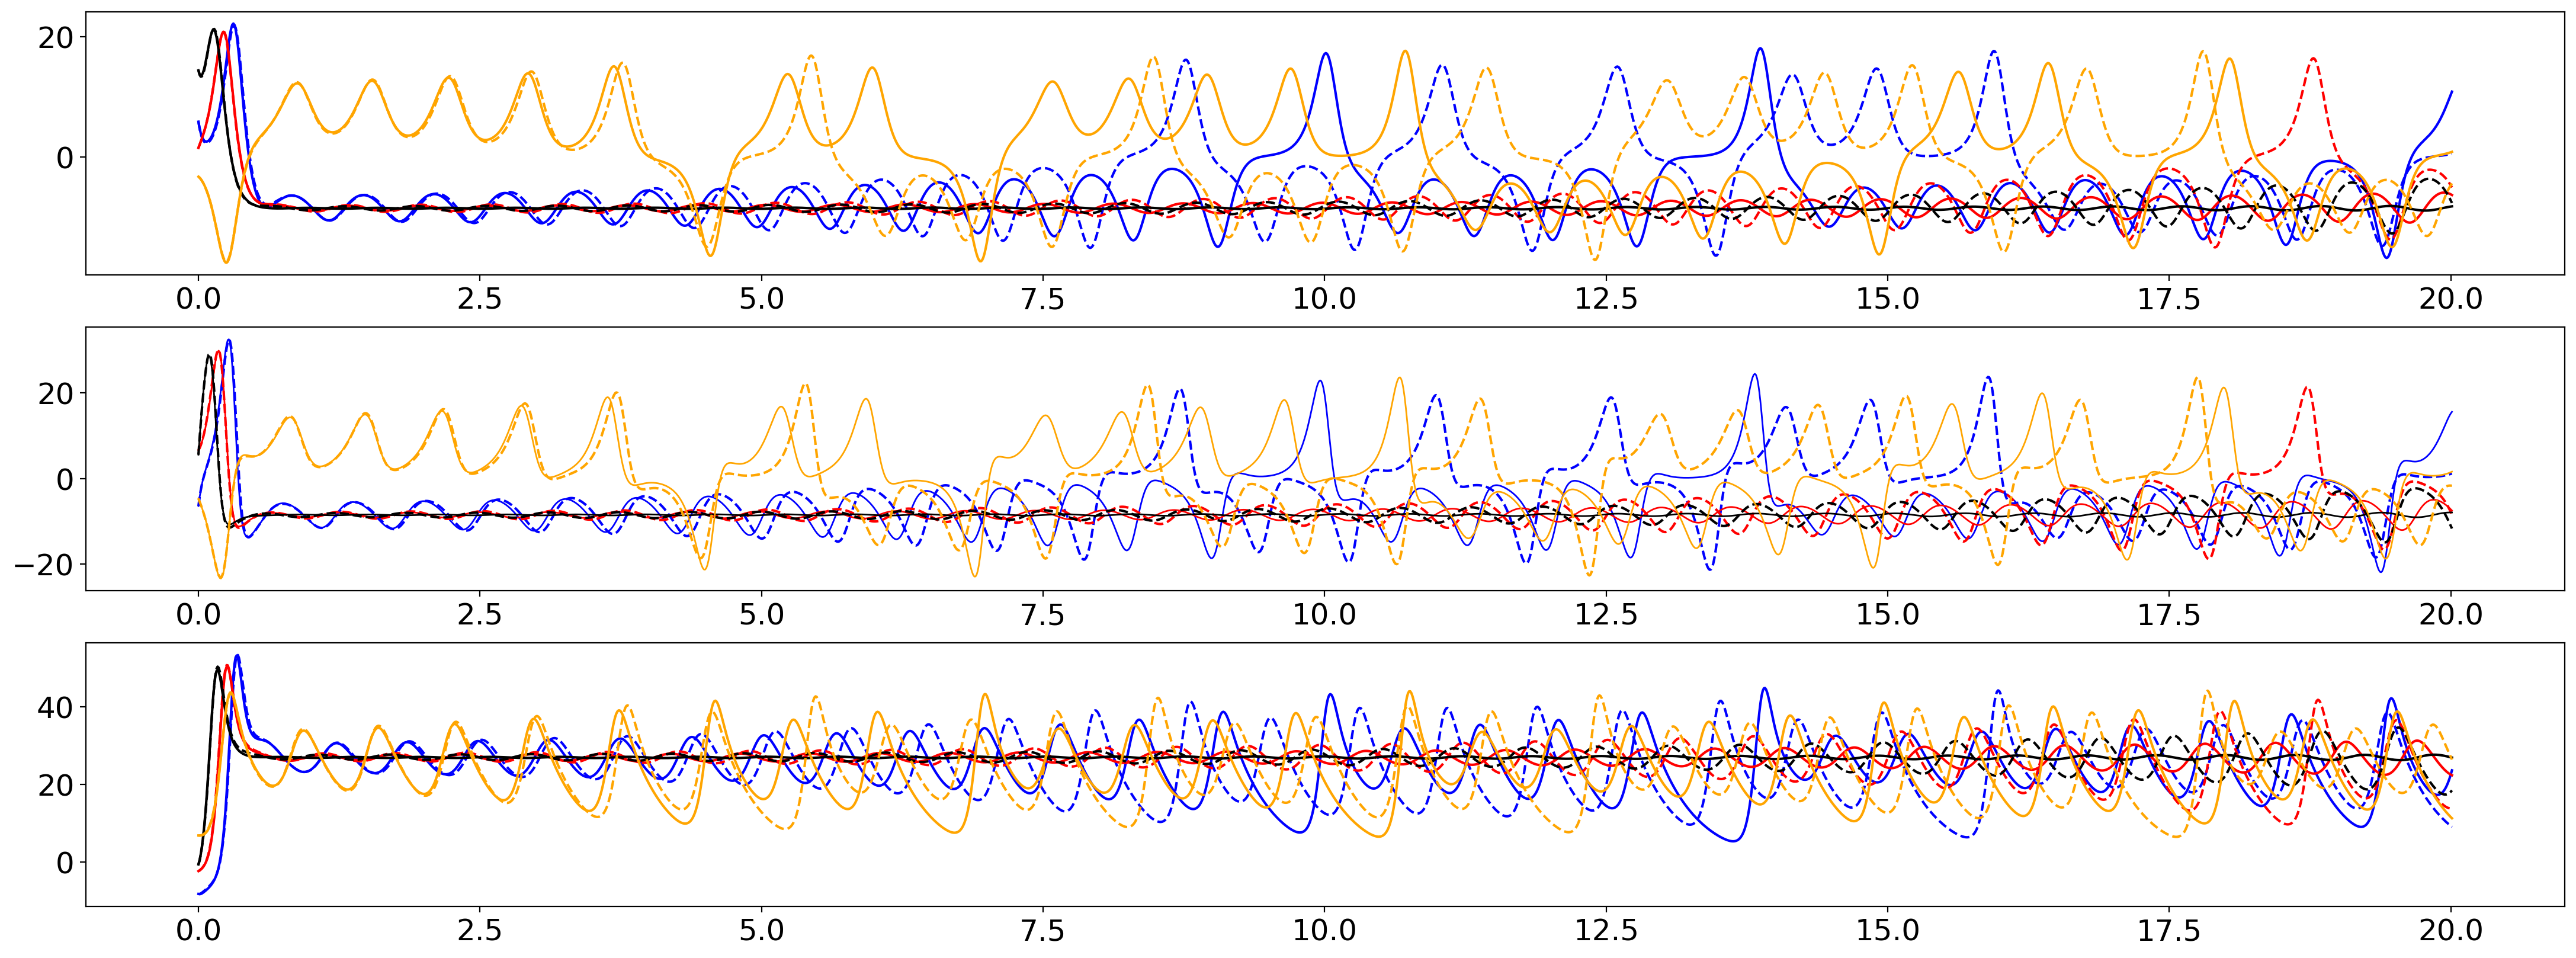

In [31]:
print(x_t_test.shape)
print(x_pred.shape)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(27, 10), dpi=200)
for j, color in zip(range(x_t_test.shape[0]),  ["blue", "red", "black", "orange"]):
    x, y, z = x_t_test[j, :, :].T
    xd, yd, zd = x_pred[j, :, :].T
    ax1.plot(t, x, c=color)
    ax1.plot(t, xd, '--', c=color)
    ax2.plot(t, y, lw=1, c=color)
    ax2.plot(t, yd, '--', c=color)
    ax3.plot(t, z, c=color) 
    ax3.plot(t, zd, '--', c=color) 

plt.show()

## Validation
We validate the dynamic system. Because the system is chaotic we cannot indefinitely match the reference. However, we can check if our prediction successfully captured properties that describe the dynamics. For instance the Lyapunov exponent or the intrinsic dimension. For the computation we use [nolitsa](https://github.com/manu-mannattil/nolitsa).

C.f. https://sprott.physics.wisc.edu/chaos/lorenzle.htm

(5000, 3)
(5000, 3)


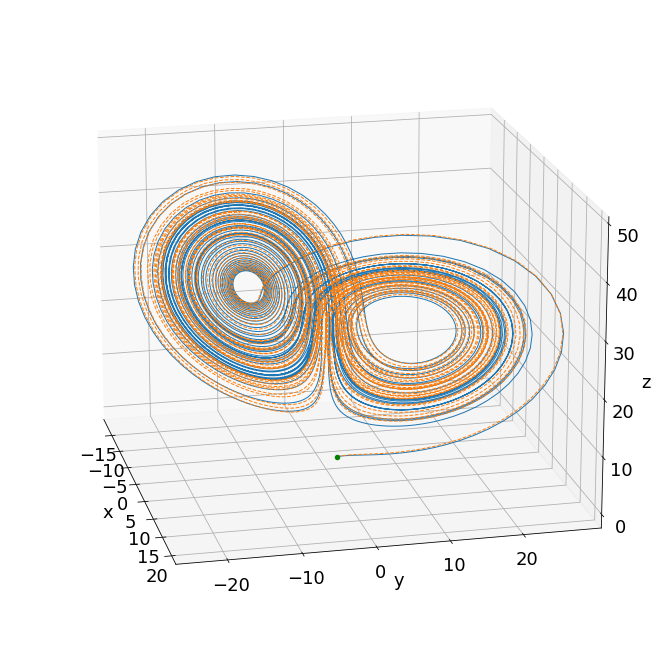

In [33]:
x0 = np.array([2, 1, 1])
target_traj = generate_data(dt, np.arange(5000) * dt, beta, sigma, rho, np.array([x0]))[0]
print(target_traj.shape)
pred_traj = rollout_data(model, np.array(x0), np.arange(5000))
print(pred_traj.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = target_traj[:, :].T
xd, yd, zd = pred_traj[:, :].T
ax.plot(x, y, z, linewidth=1)
ax.plot(xd, yd, zd, '--', lw=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(x[0], y[0], z[0], color='g')
             
ax.view_init(18, -13)
plt.show()

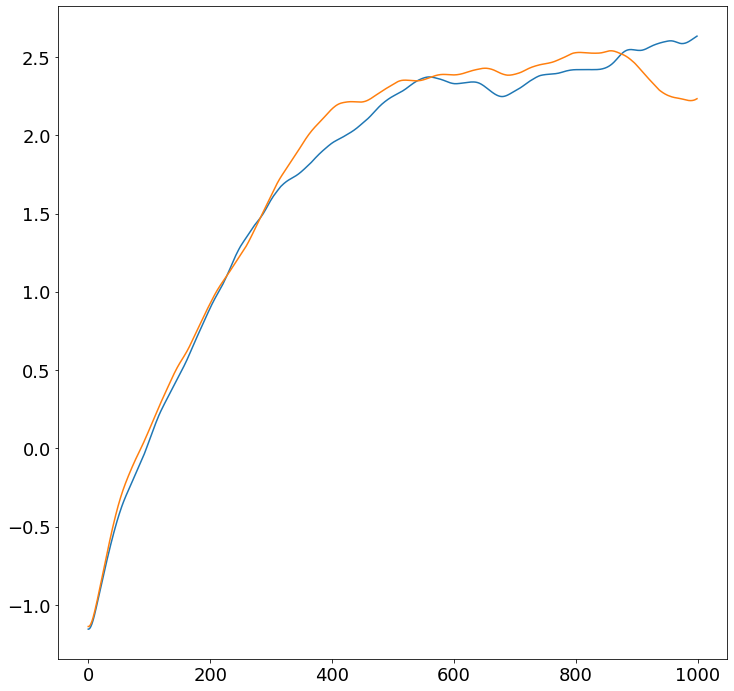

Lyapunov exponent ref: 8.120e-01, pred: 8.024e-01


In [40]:
from nolitsa import d2

from nolitsa import data, lyapunov
import numpy as np
import matplotlib.pyplot as plt

sample = 0.01
# Choose appropriate Theiler window.
window = 50

d = lyapunov.mle(target_traj, maxt=1000, window=window)
d_pred = lyapunov.mle(pred_traj, maxt=1000, window=window)
t =  np.arange(1000)

plt.plot(t, d)
plt.plot(t, d_pred)
plt.show()

coeff_ref = np.polyfit(np.arange(10, 350) * sample, d[10:350], 1)[0] 
coeff_pred = np.polyfit(np.arange(10, 350) * sample, d_pred[10:350], 1)[0]

print(f"Lyapunov exponent ref: {coeff_ref:.3e}, pred: {coeff_pred:.3e}")
print(f"Literature reports 0.906") 

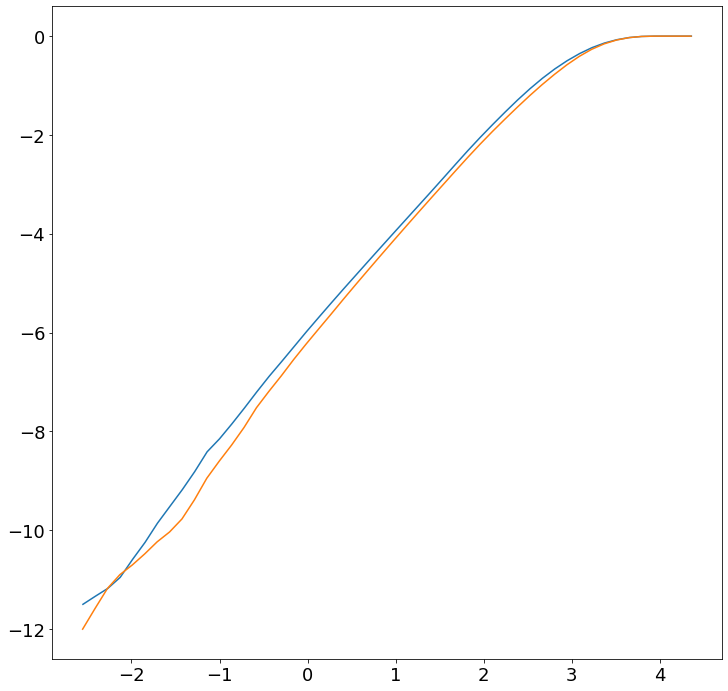

Correlation sum ref: 1.927e+00, pred: 1.978e+00


In [39]:
r_target, c_target = d2.c2(target_traj, window=window, metric="euclidean", r=50)
r_pred, c_pred = d2.c2(pred_traj, window=window, metric="euclidean", r=50)

plt.plot(np.log(r_target), np.log(c_target))
plt.plot(np.log(r_pred), np.log(c_pred))
plt.show()

coeff_ref = np.polyfit(np.log(r_target[15:40]), np.log(c_target[15:40]), 1)[0]
coeff_pred = np.polyfit(np.log(r_pred[15:40]), np.log(c_pred[15:40]), 1)[0]

print(f"Correlation sum ref: {coeff_ref:.3e}, pred: {coeff_pred:.3e}")

### Lorenz Map
ToDo

## Old and Miscellaneous
To Be Ignored.
### Training on Static Train Set
This is a classical training. We have a train, validation, and test sets. We train over 100 epochs with an exponential decay learning rate.

In [ ]:
model = Model()
logger = pl.loggers.CSVLogger("logs", name="Lorenz")
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="logs/Lorenz", save_top_k=1, monitor="val_loss")
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')
train_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(input_train).float(), torch.from_numpy(output_train).float()), batch_size=64)
val_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(input_val).float(), torch.from_numpy(output_val).float()), batch_size=64)
test_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(input_test).float(), torch.from_numpy(output_test).float()), batch_size=64)
trainer = pl.Trainer(accelerator="gpu", gpus=1, max_epochs=100, logger=logger, callbacks=[checkpoint_callback, lr_monitor])
trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_dataloader)

In [ ]:
version = 0

In [ ]:
log_file = f"logs/Lorenz/version_{version}/metrics.csv"
train_log = pd.read_csv(log_file)

In [ ]:
train_df = train_log.loc[~train_log["train_loss_epoch"].isna(), ["epoch", "train_loss_epoch"]].reset_index(drop=True).copy()
train_df.rename(columns={"train_loss_epoch": "loss"}, inplace=True)
train_df["set"] = "train"
val_df = train_log.loc[~train_log["val_loss"].isna(), ["epoch", "val_loss"]].reset_index(drop=True).copy()
val_df.rename(columns={"val_loss": "loss"}, inplace=True)
val_df["set"] = "val"
loss_df = pd.concat([train_df, val_df])

In [ ]:
p = p9.ggplot(loss_df, p9.aes(x='epoch', y='loss', color='set'))
p += p9.geom_line()
p += p9.scale_y_log10()
p += p9.labs(title="Baseline")
p.save("baseline_train.png")
p

In [ ]:
lr_df = train_log.loc[~train_log["lr"].isna(), ["lr", "step"]].reset_index(drop=True).copy()

In [ ]:
p = p9.ggplot(lr_df, p9.aes(x='step', y='lr'))
p += p9.geom_line()
p += p9.scale_y_log10()
p

In [ ]:
import glob

In [ ]:
ckpt_file = glob.glob(f"logs/Lorenz/*.ckpt")[0]

In [ ]:
model.load_from_checkpoint(ckpt_file)

In [ ]:
print(x_t_test.shape)

# from tqdm import tqdm
np.random.seed(139)

x_pred = np.zeros((x_t_test.shape[0], len(t), 3))
x_pred[:, 0, :] = x_t_test[:, 0, :]
with torch.no_grad():
    for jj, tval in enumerate(t[:-1]):
        x_pred[:, jj+1, :] = model(torch.from_numpy(x_pred[:, jj, :]).float()).numpy()

print(x_pred.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(x_t_test.shape[0]):
    x, y, z = x_t_test[j, :, :].T
    xd, yd, zd = x_pred[j, :, :].T
    ax.plot(x, y, z, linewidth=1)
    ax.plot(xd, yd, zd, '--', lw=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x[0], y[0], z[0], color='g')        
ax.view_init(18, -13)
plt.savefig("baseline_test_result_trajetories.png")
plt.show()

In [ ]:
np.sqrt(np.mean((x_pred - x_t_test) ** 2))

### Training on Dynamic Train Set
The train set is updated at every epoch. This should provide more data diversity.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    
    def generate_data(self):
        self.count = 0
        x_0 = -15 + 30 * self.rng.random((self.n_simulations, 3))
        data = torch.from_numpy(generate_data(dt, T, beta, sigma, rho, x_0)).float()
        input_data = data[:, :-1, :].reshape(-1, 3)
        output_data = data[:, 1:, :].reshape(-1, 3)
        return input_data, output_data

    def __init__(self, n_simulations):
        self.n_simulations = n_simulations
        self.count = 0
        self.rng = np.random.default_rng(seed=123)
        self.input_data, self.output_data = self.generate_data()        
        
    def __len__(self):
        return self.n_simulations * (t.size - 1)
    
    def __getitem__(self, idx):
        self.count += 1
        if self.count % self.__len__() == 0:
            self.input_data, self.output_data = self.generate_data()
        return self.input_data[idx], self.output_data[idx]

Check training set is actually updated every epoch.

In [ ]:
dataset = Dataset(10)

for batch_idx, batch in enumerate(torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)):
    x, y = batch
    if batch_idx == 0:
        print(x)
print("New epoch")
print(dataset.count)
for batch_idx, batch in enumerate(torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)):
    x, y = batch
    if batch_idx == 0:
        print(x)

In [ ]:
model = Model()
logger = pl.loggers.CSVLogger("logs", name="Lorenz")
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="logs", mode="min", monitor="val_loss")
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')
train_dataloader = torch.utils.data.DataLoader(Dataset(100), batch_size=64)
val_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(input_val).float(), torch.from_numpy(output_val).float()), batch_size=64)
test_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(input_test).float(), torch.from_numpy(output_test).float()), batch_size=64)
trainer = pl.Trainer(accelerator="gpu", gpus=1, max_epochs=100, logger=logger, callbacks=[lr_monitor])
trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
trainer.test(dataloaders=test_dataloader)

In [ ]:
version = 1

In [ ]:
log_file = f"logs/Lorenz/version_{version}/metrics.csv"
train_log = pd.read_csv(log_file)

In [ ]:
train_df = train_log.loc[~train_log["train_loss_epoch"].isna(), ["epoch", "train_loss_epoch"]].reset_index(drop=True).copy()
train_df.rename(columns={"train_loss_epoch": "loss"}, inplace=True)
train_df["set"] = "train"
val_df = train_log.loc[~train_log["val_loss"].isna(), ["epoch", "val_loss"]].reset_index(drop=True).copy()
val_df.rename(columns={"val_loss": "loss"}, inplace=True)
val_df["set"] = "val"
loss_df = pd.concat([train_df, val_df])

In [ ]:
p = p9.ggplot(loss_df, p9.aes(x='epoch', y='loss', color='set'))
p += p9.geom_line()
p += p9.scale_y_log10()
p += p9.labs(title="Dynamics training set") 
p.save("dynamics_set_train.png")
p

In [ ]:
lr_df = train_log.loc[~train_log["lr"].isna(), ["lr", "step"]].reset_index(drop=True).copy()

In [ ]:
p = p9.ggplot(lr_df, p9.aes(x='step', y='lr'))
p += p9.geom_line()
p += p9.scale_y_log10()
p

In [ ]:
print(x_t_test.shape)

# from tqdm import tqdm
np.random.seed(139)

x_pred = np.zeros((x_t_test.shape[0], len(t), 3))
x_pred[:, 0, :] = x_t_test[:, 0, :]
with torch.no_grad():
    for jj, tval in enumerate(t[:-1]):
        x_pred[:, jj+1, :] = model(torch.from_numpy(x_pred[:, jj, :]).float()).numpy()

print(x_pred.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(x_t_test.shape[0]):
    x, y, z = x_t_test[j, :, :].T
    xd, yd, zd = x_pred[j, :, :].T
    ax.plot(x, y, z, linewidth=1)
    ax.plot(xd, yd, zd, '--', lw=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x[0], y[0], z[0], color='g')
             
ax.view_init(18, -13)
plt.savefig("dynamics_training_set_test_result_trajetories.png")
plt.show()

In [ ]:
np.sqrt(np.mean((x_pred - x_t_test) ** 2))